# 1. Import des bibliothèques et modules utiles

In [1]:
import pandas as pd #Pour la manipulation des DataFrames
import numpy as np #Pour les calcul et conversions de type
import re #Module Regex. Pour chercher, nettoyer ou remplacer du texte dans les tweets
from tqdm import tqdm #Pour afficher une barre de progression lors d’une boucle longue
import matplotlib.pyplot as plt #Pour les graphiques
from transformers import pipeline #Bibliothèque de Hugging Face pour le NLP RoBERTa. Permet d'analyser les sentiments dirrects
import torch #Pour la gestion des tenseurs rapidement

# 2. Préparation des données

In [5]:
#Fonction de lecture des fichiers
def load_twitter_csv(path):
    return pd.read_csv(
        path,
        sep=";",             #séparateur
        dtype=str,           #tout en string
        encoding="utf-8",
        low_memory=False,
        quotechar='"',       # protège les textes contenant des ;
        on_bad_lines="skip"  # ignore les lignes corrompues
    )

# Chargement des deux DataFrames
trump = load_twitter_csv("data/trump_nort.csv")
biden = load_twitter_csv("data/biden_nort.csv")


#Identification des colonnes de texte. Certains CSV Kaggle ont plusieurs colonnes texte (tweet, text_clean, tweet_original). Cette fonction cherche automatiquement une colonne dont le nom contient "text"
def find_text_column(df):
    for col in df.columns:
        if "text" in col.lower():
            return col
    raise ValueError("Colonne texte introuvable")

trump_text_col = find_text_column(trump)
biden_text_col = find_text_column(biden)

#Vérification
print("Colonne Trump :", trump_text_col)
print("\n")
print("Colonne Biden :", biden_text_col)
print("\n")


Colonne Trump : text_clean


Colonne Biden : text_clean




# 3. Ajout de la colonne candidat au dataset

In [6]:
#On ajoute une colonne candidate pour identifier facilement à quel candidat appartient chaque tweet.
trump["candidate"] = "Trump"
biden["candidate"] = "Biden"

#Concatenation des deux DataFrames
df = pd.concat([trump, biden], ignore_index=True)
print("Dataset combiné :", df.shape)

#Echantillonnage car l'analyse sur tout le jeu de donnée prend trop de temps
MAX_TWEETS = 50000  # par candidat

df_sample = (
    df.groupby("candidate", group_keys=False)
      .apply(lambda x: x.sample(n=min(MAX_TWEETS, len(x)), random_state=42))
)

print("Dataset échantillonné :", df_sample.shape)

trump_sample = df_sample[df_sample['candidate'] == 'Trump']
biden_sample = df_sample[df_sample['candidate'] == 'Biden']


Dataset combiné : (1210621, 26)
Dataset échantillonné : (100000, 26)


/tmp/ipython-input-431515733.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=min(MAX_TWEETS, len(x)), random_state=42))


#  4. Préparation du modèle Hugging Face

In [7]:
#Chargement du modèle avec l'interface simplifiée de HF.
sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model="cardiffnlp/twitter-xlm-roberta-base-sentiment", #Modèle pré-entrainé
    tokenizer="cardiffnlp/twitter-xlm-roberta-base-sentiment", #Transforme le texte en token que le modèle peut comprendre
    device=0  #Pour utiliser le GPU. Changer par -1 si vous vous utiliser le CPU
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/841 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

XLMRobertaForSequenceClassification LOAD REPORT from: cardiffnlp/twitter-xlm-roberta-base-sentiment
Key                             | Status     |  | 
--------------------------------+------------+--+-
roberta.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

# 5. Analyse des sentiments

In [8]:
torch.set_grad_enabled(False) #Désactivation du gradient

def analyze_sentiment(texts, batch_size=64): #Fonction d'analyse de tweets par batch
    results = []
    texts = texts.tolist()

    for i in tqdm(range(0, len(texts), batch_size)):
        batch = texts[i:i + batch_size]
        preds = sentiment_pipeline(batch)
        results.extend(preds)

    return results

print("Analyse des sentiments...")

#Implémentation sur les échantillons
trump_sentiments = analyze_sentiment(trump_sample[trump_text_col]) #Label du tweet et score du tweet entre 0 et 1
biden_sentiments = analyze_sentiment(biden_sample[biden_text_col])

#Ajout des résultats dans le DataFrame
trump_sample.loc[:, "sentiment"] = [s["label"] for s in trump_sentiments]
trump_sample.loc[:, "score"]     = [s["score"] for s in trump_sentiments]

biden_sample.loc[:, "sentiment"] = [s["label"] for s in biden_sentiments]
biden_sample.loc[:, "score"]     = [s["score"] for s in biden_sentiments]


Analyse des sentiments...


100%|██████████| 782/782 [08:46<00:00,  1.49it/s]
/tmp/ipython-input-1140385717.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trump_sample.loc[:, "sentiment"] = [s["label"] for s in trump_sentiments]
/tmp/ipython-input-1140385717.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trump_sample.loc[:, "score"]     = [s["score"] for s in trump_sentiments]
/tmp/ipython-input-1140385717.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

# 6. Résumé statistiques

In [11]:
summary_trump = trump_sample.groupby("sentiment").size().reset_index(name="count")
summary_biden = biden_sample.groupby("sentiment").size().reset_index(name="count")

summary_trump["candidate"] = "Trump"
summary_biden["candidate"] = "Biden"

# Combiner les deux
summary = pd.concat([summary_trump, summary_biden], ignore_index=True)
print(summary)


  sentiment  count candidate
0  negative  33230     Trump
1   neutral  12919     Trump
2  positive   3851     Trump
3  negative  23841     Biden
4   neutral  18295     Biden
5  positive   7864     Biden


# 7. Sauvegarde dans un fichier CSV

In [12]:
# On combine les deux échantillons (Trump + Biden)
df_sample = pd.concat([trump_sample, biden_sample], ignore_index=True)
print(df_sample.head())
df_sample.to_csv("tweets_with_sentiment.csv", index=False)
summary.to_csv("sentiment_summary.csv", index=False)

print("\n Analyse terminée et sauvegardée")

                  created_at                tweet_id  \
0  2020-11-06 13:21:53+00:00  1.3247035516465398e+18   
1  2020-10-17 15:35:12+00:00  1.3174893467656724e+18   
2  2020-11-04 03:47:44+00:00  1.3238342895874458e+18   
3  2020-11-04 22:00:59+00:00  1.3241094128737567e+18   
4  2020-11-04 22:25:17+00:00  1.3241155266254684e+18   

                                               tweet likes retweet_count  \
0  the future does not belong to globalists the f...   7.0           3.0   
1  i m sure user another time is 2 wks after trum...   0.0           0.0   
2  back on truck folkss trump trump2020 4 more years   0.0           0.0   
3  user jetzt wo trump auch michigan verloren hat...   1.0           0.0   
4  trump ha 230 grandi elettori ma 270 sul campo ...   3.0           0.0   

                source                 user_id         user_name  \
0      Twitter Web App  1.3163146262971392e+18            ANEMAS   
1     Twitter for iPad             269403495.0          Isabel G   
2 

# 8. Visualisation

      candidate                                         text_clean sentiment  \
0         Trump  the future does not belong to globalists the f...   neutral   
1         Trump  i m sure user another time is 2 wks after trum...   neutral   
2         Trump  back on truck folkss trump trump2020 4 more years  positive   
3         Trump  user jetzt wo trump auch michigan verloren hat...  negative   
4         Trump  trump ha 230 grandi elettori ma 270 sul campo ...   neutral   
...         ...                                                ...       ...   
99995     Biden  user counted in tx because our democracy is on...   neutral   
99996     Biden  trump wants you to focus on what he thinks bid...   neutral   
99997     Biden  tucker carlson interview biden corruptbidenfam...   neutral   
99998     Biden  full video that biden camp doctored user shoul...  negative   
99999     Biden  eminem endorses biden literally the next day e...   neutral   

          score  
0      0.355629  
1  

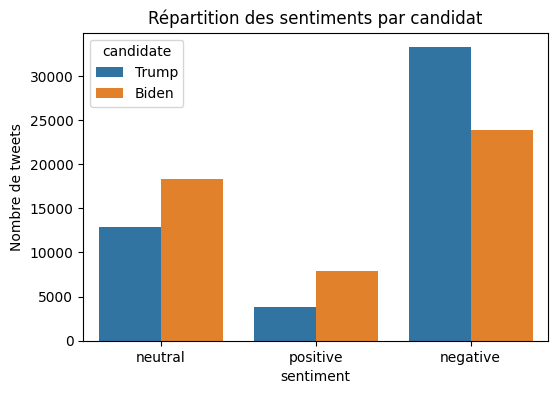

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
# Concaténer les DataFrames analysés
df_result = pd.concat([trump_sample, biden_sample], ignore_index=True)

# Vérifier que tout est correct
print(df_result[["candidate", trump_text_col, "sentiment", "score"]])

plt.figure(figsize=(6,4))
sns.countplot(data=df_result, x="sentiment", hue="candidate")
plt.title("Répartition des sentiments par candidat")
plt.ylabel("Nombre de tweets")
plt.show()


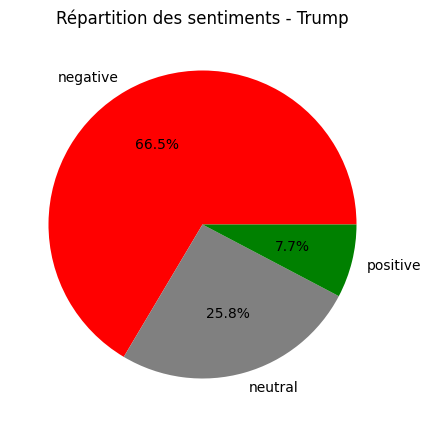

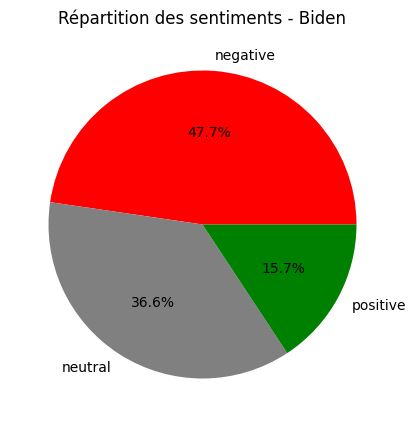

In [14]:
for candidate in ["Trump", "Biden"]:
    data = df_result[df_result["candidate"] == candidate]["sentiment"].value_counts()
    plt.figure(figsize=(5,5))
    plt.pie(data, labels=data.index, autopct="%1.1f%%", colors=["red","grey","green"])
    plt.title(f"Répartition des sentiments - {candidate}")
    plt.show()
